# Notes
    1) Check if ns6 data is automatically adjusted by gain and offset
    2) Add 0's to z property in electrodes table
    3) Ask how to set Location information

In [1]:
# import needed toolboxes
from HatLabNWBConverters_with_neuroconv import MarmForageNWBConverter
from pprint import pprint
from pathlib import Path
from neuroconv.utils import load_dict_from_file
from neuroconv.utils.json_schema import dict_deep_update
from neuroconv.tools.spikeinterface import add_devices, add_electrode_groups
from pynwb import NWBFile, NWBHDF5IO
from pynwb.image import ImageSeries, RGBImage
from pynwb.base import Images
from nwbwidgets import nwb2widget
from os.path import join as pjoin
from importlib import reload, sys
import glob
import yaml
import numpy as np
import pandas as pd
import os

sys.path.insert(0, '/project/nicho/projects/marmosets/code_database/data_processing/nwb_tools/hatlab_nwb_tools/')
from hatlab_nwb_functions import *

/project/nicho/environments/spyder/lib/python3.9/site-packages/plotly/graph_objects/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/project/nicho/environments/spyder/lib/python3.9/site-packages/plotly/graph_objects/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/project/nicho/environments/spyder/lib/python3.9/site-packages/plotly/graph_objects/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/project/nicho/environments/spyder/lib/python3.9/site-packages/plotly/graph_objects/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ip

In [2]:
reload(sys.modules['HatLabNWBConverters_with_neuroconv'])
from HatLabNWBConverters_with_neuroconv import MarmForageNWBConverter
reload(sys.modules['hatlab_nwb_functions'])
from hatlab_nwb_functions import *

In [4]:
# User defined inputs
dpath = '/project/nicho/data/marmosets/electrophys_data_for_processing/'
#app_path = '/project/nicho/data/marmosets/kinematics_videos/test/TYJL/2022_10_24/avi_videos/'
#enc_path = '/project/nicho/data/marmosets/kinematics_videos/test_free/TYJL/2022_10_24/avi_videos/'
sess = 'MG20230317_1353_mothsAndFree'
rfile = 'MG20230317_1353_mothsAndFree001.ns6'
nfile = 'MG20230317_1353_mothsAndFree001.nev'
mfile = 'MG_complete_metadata.yml'
sfile = 'tony.yml'
ofile = 'MG20230317_1353_mothsAndFree001_TESTING.nwb'
prbfile = '/project/nicho/data/marmosets/prbfiles/MG_01.prb' # name of probe (.prb) file

nwbfile_path = pjoin(dpath, sess, ofile)

filter_dict = {'6': 'None'}
stub_test= False

In [4]:
# Get source_schema
source_schema = MarmForageNWBConverter.get_source_schema()

In [5]:
# Construct the source data
base_path          = pjoin(dpath, sess)
file_recording_raw = pjoin(base_path, rfile)
file_sorting       = pjoin(base_path, nfile)
#app_video_files    = sorted(glob.glob(pjoin(app_path, '*s1*.avi')))[:2]
#enc_video_files    = sorted(glob.glob(pjoin(enc_path, '*s1*.avi')))[0]

source_data = dict(BlackrockRecordingInterfaceRaw=dict(file_path=file_recording_raw),
                   BlackrockSortingInterface=dict(file_path=file_sorting))

# if len(app_video_files)>0:
#     source_data.update(ApparatusBehaviorVideos=dict(file_paths=app_video_files))    
# if len(enc_video_files)>0:
#     source_data.update(EnclosureBehaviorVideos=dict(file_paths=enc_video_files))  
    
# len(source_data['ApparatusBehaviorVideos']['file_paths'])


In [6]:
# Initialize converter
converter = MarmForageNWBConverter(source_data=source_data)

print('Data interfaces for this converter:')
pprint(converter.data_interface_objects, width=120)

Source data is valid!
Data interfaces for this converter:
{'BlackrockRecordingInterfaceRaw': <neuroconv.datainterfaces.ecephys.blackrock.blackrockdatainterface.BlackrockRecordingInterface object at 0x7f12c40ff610>,
 'BlackrockSortingInterface': <neuroconv.datainterfaces.ecephys.blackrock.blackrockdatainterface.BlackrockSortingInterface object at 0x7f12c4150d00>}


In [7]:
# # Get metadata_schema
# metadata_schema = converter.get_metadata_schema()
# #pprint(metadata_schema, width=120)
# metadata_schema['properties']['Behavior']['properties']['Movies']
# # for key in metadata_schema['properties']['Behavior'].keys():
# #     print('%s:' %key)

In [8]:
# Get metadata from source data and from file
metadata = converter.get_metadata()
# load exp metadata
#m = load_dict_from_file('/project/nicho/projects/marmosets/code_database/data_processing/nwb_tools/session_metadata.yml')
m = load_dict_from_file(mfile)
metadata = dict_deep_update(metadata, m, append_list=False, remove_repeats=True)

# add session description and notes
try:
    text_file = glob.glob(pjoin(os.path.dirname(file_recording_raw), '*.txt'))[0]
    with open(text_file) as f:
        text  = f.read()
    with open(text_file) as f:
        lines = f.readlines() 
    metadata['NWBFile']['session_description'] = lines[0].replace('\n', '')
    metadata['NWBFile']['notes'] = text

except:
    print('could not find a notes file in %s' % os.path.dirname(file_recording_raw))

# add identifier
metadata['NWBFile']['identifier'] = os.path.basename(file_recording_raw).split('.')[0]


converter.validate_metadata(metadata)


Metadata is valid!


In [9]:
metadata

{'NWBFile': {'session_description': 'REAL test recording session for Midge array with Moths.',
  'identifier': 'MG20230317_1353_mothsAndFree001',
  'session_start_time': '2023-03-17T19:01:59',
  'experimenter': ['Jeff Walker'],
  'institution': 'University of Chicago',
  'lab': 'Hatsopoulos Lab',
  'notes': 'REAL test recording session for Midge array with Moths.\n\n1:53 PM 3/17/2023\n\nall setup for moths and free session\n\n2:00 PM 3/17/2023\nturning on the exilis\n2:02 PM 3/17/2023]\nstarted the recording 001\n2:02 PM 3/17/2023\nstartede camera scripts\n2:04 PM 3/17/2023\nissue with camera triggering\n2:05 PM 3/17/2023\nstopped recording 001. turing off exilis\n\n2:15 PM 3/17/2023cameras ready.  going to turn on exilis. \n2:16 PM 3/17/2023\nstarting neural data file 002. camera session will be #1\nstarted recording.  goingto open the apparattus to trigger cam\n\n2:56 PM 3/17/2023\ntaking a break after a series of decent moth capture episodes, moths are not expressing dynamic behavio

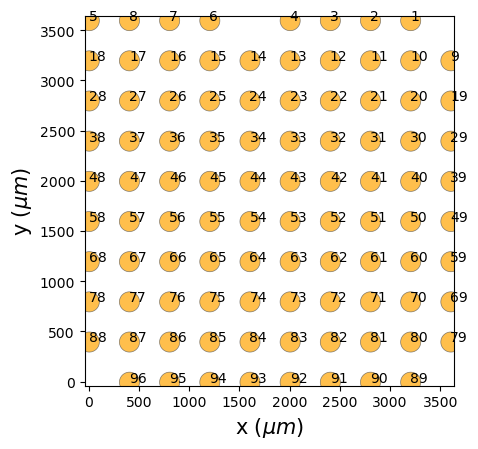

,probe_index,x,y,contact_shapes,radius,shank_ids,contact_ids,imp,z
0,0,3600.0,1600.0,circle,100.0,elec49,,<=50,-1000.0
1,1,2000.0,2400.0,circle,100.0,elec33,,<=50,-1000.0
2,2,3200.0,1600.0,circle,100.0,elec50,,<=50,-1000.0
3,3,1600.0,2400.0,circle,100.0,elec34,,<=50,-1000.0
4,4,2800.0,1600.0,circle,100.0,elec51,,<=50,-1000.0
...,...,...,...,...,...,...,...,...,...
91,91,0.0,800.0,circle,100.0,elec78,,<=50,-1000.0
92,92,800.0,0.0,circle,100.0,elec95,,51,-1000.0
93,93,3600.0,400.0,circle,100.0,elec79,,<=50,-1000.0
94,94,400.0,0.0,circle,100.0,elec96,,<=50,-1000.0


In [5]:
reload(sys.modules['hatlab_nwb_functions'])
from hatlab_nwb_functions import *

arraymap, impedances = read_prb_hatlab(prbfile)
plot_prb(arraymap)
map_df=arraymap.to_dataframe()
map_df['imp'] = [imp for imp in impedances]
if 'z' not in map_df.keys():
    map_df['z'] = np.repeat(-1000.0, map_df.shape[0])
map_df

In [11]:
array_group = [group for group in metadata['Ecephys']['ElectrodeGroup'] if 'ainp' not in group['name'].lower()][0]
analog_group = [group for group in metadata['Ecephys']['ElectrodeGroup'] if 'ainp' in group['name'].lower()][0]
# analog_group

In [12]:
raw_extractor = converter.data_interface_objects['BlackrockRecordingInterfaceRaw'].recording_extractor 
raw_extractor._properties

{'gain_to_uV': array([  0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.

In [21]:
chNames

array(['elec49', 'elec33', 'elec50', 'elec34', 'elec51', 'elec35',
       'elec52', 'elec36', 'elec53', 'elec37', 'elec54', 'elec38',
       'elec55', 'elec39', 'elec56', 'elec40', 'elec57', 'elec41',
       'elec58', 'elec42', 'elec59', 'elec43', 'elec60', 'elec44',
       'elec61', 'elec45', 'elec62', 'elec46', 'elec63', 'elec47',
       'elec64', 'elec48', 'elec17', 'elec1', 'elec18', 'elec2', 'elec19',
       'elec3', 'elec20', 'elec4', 'elec21', 'elec5', 'elec22', 'elec6',
       'elec23', 'elec7', 'elec24', 'elec8', 'elec25', 'elec9', 'elec26',
       'elec10', 'elec27', 'elec11', 'elec28', 'elec12', 'elec29',
       'elec13', 'elec30', 'elec14', 'elec31', 'elec15', 'elec32',
       'elec16', 'elec81', 'elec65', 'elec82', 'elec66', 'elec83',
       'elec67', 'elec84', 'elec68', 'elec85', 'elec69', 'elec86',
       'elec70', 'elec87', 'elec71', 'elec88', 'elec72', 'elec89',
       'elec73', 'elec90', 'elec74', 'elec91', 'elec75', 'elec92',
       'elec76', 'elec93', 'elec77', 'ele

In [25]:
swap_ab=False
if swap_ab:
    chIDs = raw_extractor.get_channel_ids()
    chNames = raw_extractor._properties['channel_name']
    reorder = list(range(32, 64)) + list(range(0, 32)) + list(range(64, 99))
    chNames = np.array([chNames[idx] for idx in reorder])
    chNames
    raw_extractor.set_property('channel_name', chNames)
    raw_extractor._properties

{'gain_to_uV': array([  0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.

In [195]:
raw_extractor = converter.data_interface_objects['BlackrockRecordingInterfaceRaw'].recording_extractor 

chIDs = raw_extractor.get_channel_ids()
chNames = raw_extractor._properties['channel_name']
array_chans = [ch for ch, name in zip(chIDs, chNames) if 'ainp' not in name]
analog_chans = [ch for ch in chIDs if ch not in array_chans]

raw_extractor.set_property('x', map_df['x'], ids=array_chans, missing_value=None)
raw_extractor.set_property('y', map_df['y'], ids=array_chans, missing_value=None)
raw_extractor.set_property('z', map_df['z'], ids=array_chans, missing_value=None)

# set properties of utah array channels
raw_extractor.set_channel_groups([array_group['name']]*len(array_chans), array_chans)
raw_extractor.set_channel_groups([analog_group['name']]*len(analog_chans), analog_chans)


raw_extractor.set_property('filtering', [filter_dict[rfile[-1]]]*len(chIDs))

array_locations = np.expand_dims([array_group['location']]*len(array_chans), -1)
raw_extractor.set_property('brain_region', [array_group['location']]*len(array_chans), ids= array_chans, missing_value=None)

raw_extractor.set_property('imp', [float(str(imp).replace('<=', '')) for imp in map_df['imp'].values], ids=array_chans, missing_value=None)

raw_extractor._properties

{'gain_to_uV': array([  0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.25      ,   0.25      ,   0.25      ,
          0.25      ,   0.

In [196]:
sorting_extractor = converter.data_interface_objects['BlackrockSortingInterface'].sorting_extractor
chIDs = sorting_extractor.get_unit_ids()
if len(raw_extractor._properties['channel_name']) > len(chIDs[:len(raw_extractor._properties['channel_name'])]):
    sorting_extractor.set_property('channel_name', raw_extractor._properties['channel_name'][:len(chIDs)], chIDs, missing_value=None)
else:
    sorting_extractor.set_property('channel_name', raw_extractor._properties['channel_name'], chIDs[:len(raw_extractor._properties['channel_name'])], missing_value=None)

In [197]:
sorting_extractor._properties

{'channel_name': array(['elec49', 'elec33', 'elec50', 'elec34', 'elec51', 'elec35',
        'elec52', 'elec36', 'elec53', 'elec37', 'elec54', 'elec38',
        'elec55', 'elec39', 'elec56', 'elec40', 'elec57', 'elec41',
        'elec58', 'elec42', 'elec59', 'elec43', 'elec60', 'elec44',
        'elec61', 'elec45', 'elec62', 'elec46', 'elec63', 'elec47',
        'elec64', 'elec48', 'elec17', 'elec1', 'elec18', 'elec2', 'elec19',
        'elec3', 'elec20', 'elec4', 'elec21', 'elec5', 'elec22', 'elec6',
        'elec23', 'elec7', 'elec24', 'elec8', 'elec25', 'elec9', 'elec26',
        'elec10', 'elec27', 'elec11', 'elec28', 'elec12', 'elec29',
        'elec13', 'elec30', 'elec14', 'elec31', 'elec15', 'elec32',
        'elec16', 'elec81', 'elec65', 'elec82', 'elec66', 'elec83',
        'elec67', 'elec84', 'elec68', 'elec85', 'elec69', 'elec86',
        'elec70', 'elec87', 'elec71', 'elec88', 'elec72', 'elec89',
        'elec73', 'elec90', 'elec74', 'elec91', 'elec75', 'elec92',
        'el

In [198]:
# conversion schema
conversion_options_schema = converter.get_conversion_options_schema()
conversion_options = converter.get_conversion_options()
# conversion_options

In [199]:
# build conversion options
conversion_options = converter.get_conversion_options()
conversion_options['BlackrockRecordingInterfaceRaw']=dict(stub_test=stub_test)
conversion_options['BlackrockSortingInterface']=dict(stub_test=stub_test, write_ecephys_metadata=False)
# conversion_options['ApparatusBehaviorVideos']=dict(stub_test=stub_test, 
#                                                    starting_times=[855.66, 900.0],
#                                                   )
# get video start times
#conversion_options['KinematicVideos'] = dict(starting_times=kstart_times)

In [200]:
converter.run_conversion(
    metadata=metadata, 
    nwbfile_path=nwbfile_path, 
    conversion_options=conversion_options,
)

Metadata is valid!
conversion_options is valid!


/project/nicho/environments/spyder/lib/python3.9/site-packages/pynwb/file.py:1100: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/project/nicho/environments/spyder/lib/python3.9/site-packages/neuroconv/tools/spikeinterface/spikeinterface.py:997: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  distutils.version.LooseVersion(pynwb.__version__) >= "1.3.3"
/project/nicho/environments/spyder/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/project/nicho/environments/spyder/lib/python3.9/site-packages/neuroconv/tools/spikeinterface/spikeinterface.py:271: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(pynwb.__version__) 

NWB file saved at /project/nicho/data/marmosets/electrophys_data_for_processing/MG20230317_1353_mothsAndFree/MG20230317_1353_mothsAndFree001_TESTING.nwb!


root pynwb.file.NWBFile at 0x140213379508784
Fields:
  acquisition: {
    ElectricalSeriesRaw <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    Cerebus AnalogIn <class 'pynwb.device.Device'>,
    Utah Array (M1) <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    MG_array_1 <class 'pynwb.ecephys.ElectrodeGroup'>,
    ainp <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experimenter: ['Jeff Walker']
  file_create_date: [datetime.datetime(2023, 3, 23, 14, 40, 36, 543138, tzinfo=tzlocal())]
  identifier: MG20230317_1353_mothsAndFree001
  institution: University of Chicago
  keywords: ['exp1' 'exp2']
  lab: Hatsopoulos Lab
  notes: REAL test recording session for Midge array with Moths.

1:53 PM 3/17/2023

all setup for moths and free session

2:00 PM 3/17/2023
turning on the exilis
2:02 PM 3/17/2023]
started the recording 001
2:02 PM 3/17/2023
startede camera scripts
2:04 PM 3/17/2023
issue with camera trig

In [158]:

with NWBHDF5IO(nwbfile_path, 'r+') as io:
    nwbfile = io.read()

    image_files = glob.glob(os.path.join(os.path.dirname(nwbfile_path), '*png'))
    screenshot_images = []
    for f in image_files:
        if 'plots' not in f:
            tmp_img = RGBImage(name=os.path.basename(f),
                               data=plt.imread(f)[..., :3])
            screenshot_images.append(tmp_img)

    screenshots = Images(name='screenshots of neural data acquisition',
                         images=screenshot_images,
                         description='may include spike panel, single neural channel, raster, and IP cam footage')

    nwbfile.add_acquisition(screenshots)    

    io.write(nwbfile)        

print('%s opened, edited, and written back to file. It is now closed.' % nwbfile_path)


/project/nicho/data/marmosets/electrophys_data_for_processing/MG20230317_1353_mothsAndFree/MG20230317_1353_mothsAndFree001_TESTING.nwb opened, edited, and written back to file. It is now closed.


In [156]:
os.path.join(os.path.dirname(nwbfile_path), '*png')

'/project/nicho/data/marmosets/electrophys_data_for_processing/MG20230317_1353_mothsAndFree/*png'

In [201]:
io = NWBHDF5IO(nwbfile_path, 'r')
nwbfile = io.read()
nwb2widget(nwbfile)

<StrDataset for HDF5 dataset "keywords": shape (2,), type "|O">


In [203]:
nwbfile.keywords[:]

array(['exp1', 'exp2'], dtype=object)

In [204]:
io.close()